# Investigate training data

The training data are a bit messy, we can't really be sure which badges were used as the numbering sheme doesn't seem to match up.

This notebook tries to answer the burning question of _which badges do we care about?_

In [1]:
import json
import pickle
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import networkx as nx
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from shapely.geometry.polygon import LinearRing

import helpers

In [2]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 10)

In [3]:
def draw_infrastructure(title="Sticker and Base Station Locations", 
                        draw_graph=False, 
                        draw_img=False, 
                        draw_boundaries=False,
                        draw_axes=False, 
                        draw_stickers=False, 
                        draw_basestations=False, 
                        draw_seat_names=False,
                        pad_x_pc=0.05, 
                        pad_y_pc=0.01,
                        sticker_label_size=7, 
                        name_label_size=5, 
                        base_label_size=10,
                        return_plt_object=False,
                        verbose=False):
    """Draw the fixed infrastructure of the sensicorn project."""
        
    def plot_line(ob, colour="r"):
        x, y = ob.xy
        plt.plot(x, y, color=colour, alpha=0.7, linewidth=1, solid_capstyle='round', zorder=2)
    
    fig, ax = plt.subplots()

    plt.title(title)
    
    legend_items = []
    
    # set axis limits with a bit of padding
    x = [pair[0] for pair in outer[0]] # get boundary limits
    y = [pair[1] for pair in outer[0]]
    pad_y = (max(y) - min(y)) * pad_y_pc
    pad_x = (max(x) - min(x)) * pad_x_pc
    axes = plt.gca()
    axes.set_ylim([min(y) - pad_y, max(y) + pad_y])
    axes.set_xlim([min(x) - pad_x, max(x) + pad_x])
    
    if draw_img:
        # put the image on the graph as an underlay
        img = imread("map.png")
        ax.imshow(img, zorder=0, extent=[-1300, 72000, -24000, 41000])
        #                                [left, right, bottom, top  ]

    if draw_boundaries:
        for boundary_set, colour in [(inner, "r"),(isovist, "g"),(outer, "b")]:
            for e in boundary_set:
                ring = LinearRing(e)
                plot_line(ring, colour)
        legend_inner = mlines.Line2D([], [], color='r', label='Inner Boundary')
        legend_isovist = mlines.Line2D([], [], color='g', label='Isovist Boundary')
        legend_outer = mlines.Line2D([], [], color='b', label='Outer Boundary')
        legend_items.extend([legend_inner, legend_isovist, legend_outer])

    if draw_graph:
        pos = {n[0]: (n[1]["x"], n[1]["y"]) for n in OG.nodes(data=True)}
        nx.draw(OG, alpha=0.3, s=1, pos=pos, node_shape=".", node_size=10)  # don't draw the graph

    if draw_basestations:
        # put the baseStations on the map
        for index, row in baseStationData.iterrows():
            if not math.isnan(row.x) and not math.isnan(row.y):
                ax.text(row.x, row.y, row.agentName, fontsize=base_label_size)
            else:
                if verbose:
                    print(row.x, row.y, row.agentName, "not shown because probably not used.")
                else:
                    pass
        base_stations = ax.scatter(baseStationData.x, baseStationData.y, marker='+', label='base stations')
        legend_items.append(base_stations)

    if not draw_axes:
        # Hide the axis numbers because they don't tell us much
        ax.xaxis.set_major_formatter(plt.NullFormatter())
        ax.yaxis.set_major_formatter(plt.NullFormatter())

    if draw_stickers:
        # the sticker labels
        for _, row in stickerLocations.iterrows():
            ax.text(row.x, row.y, "{0:03d}".format(int(row.stickerID)), fontsize=sticker_label_size)

        # sticker dots
        stickers = ax.scatter(stickerLocations.x, stickerLocations.y, s=1, c="y", label='stickers')
        legend_items.append(stickers)
    
    if draw_seat_names:
        for _, row in seats.iterrows():
            ax.text(row.x, row.y, row["name"], fontsize=name_label_size, rotation=10) # .name must be a reserved word?

        # sticker dots
        seat_pos = ax.scatter(seats.x, seats.y, s=1, c="y", label='seats')
        legend_items.append(seat_pos)
        
    
    if len(legend_items) > 0:
        # red_patch = mpatches.Patch(color='red', label='The red data') # patch example
        plt.legend(handles=legend_items, loc='upper left')

    if return_plt_object:
        return (fig, ax)
    else:
        plt.show()

# off we go:

Get the data out of the pickle. This is pickled by the `load candidate data from csv` notebook.

This is what we're dealing with:

In [4]:
c_data = pd.read_pickle("candidate_data.p")
c_data.head()

,minor,time,rssi,agentId
0,288,2016-11-23 23:06:34.012,-72,000000007d418b7a
1,288,2016-11-23 23:06:34.019,-82,00000000029d74c5
2,360,2016-11-23 23:06:34.059,-96,00000000c7ce4c76
3,360,2016-11-23 23:06:34.061,-75,000000005e6ed248
4,360,2016-11-23 23:06:34.061,-87,00000000fc7843f8


In [5]:
d = pickle.load( open( "infrastructure_store.p", "rb" ) )    

stickerLocations = pd.DataFrame.from_dict(d["stickerLocations"])
baseStationData  = pd.DataFrame.from_dict(d['baseStationData'])
seats            = pd.DataFrame.from_dict(d['seats'])
outer   = d['outer']
inner   = d['inner']
isovist = d['isovist']

# print ("stickerLocations")
# print (stickerLocations.head(2))
# print ("\n\nbaseStationData")
# print (baseStationData.head(2))
# print ("\n\nouter")
# print (outer[0])
# print ("\n\ninner")
# print (inner[0])
# print ("\n\nseats")
# print (seats.head(2))
# print ("\n\nisovist")
# print (isovist[0])
    
OG = nx.read_gpickle("graph.p")
# if graph.p can't be found, run BVN infrastructure and layout first

If we just have a look at what we've got here:

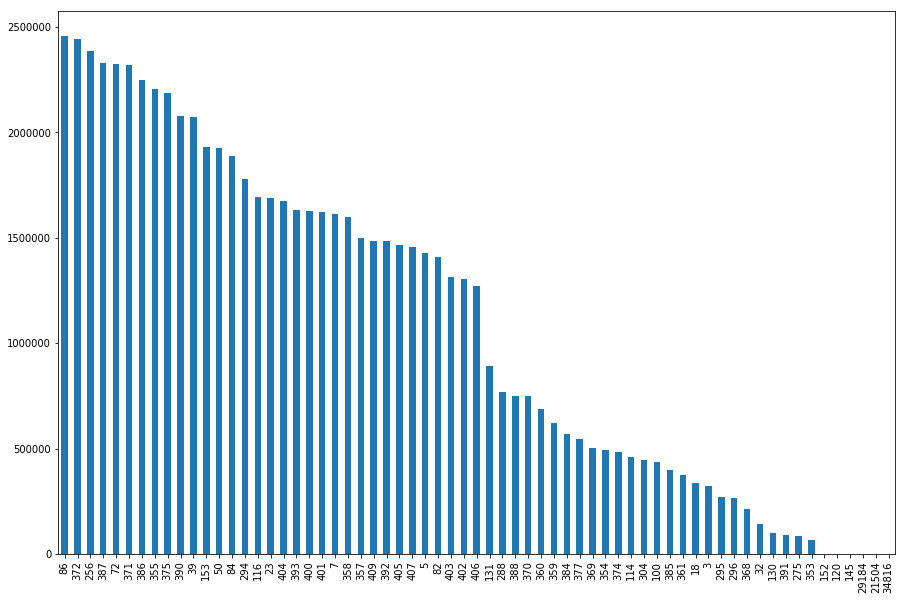

In [6]:
c_data.minor.value_counts().plot(kind="bar")

I don't really understand this, seems odd that some badges would be recorded more than others. If the badges broadcast once a seconds then I'd imagine that they should all be _more or less_ the same. I guess we'll see...

In [7]:
x = baseStationData[["agentId", "agentName"]]
c_data = c_data.merge(x, on="agentId")
del x
c_data.head()

,minor,time,rssi,agentId,agentName
0,288,2016-11-23 23:06:34.012,-72,000000007d418b7a,Monkey
1,404,2016-11-23 23:06:34.075,-74,000000007d418b7a,Monkey
2,23,2016-11-23 23:06:34.076,-84,000000007d418b7a,Monkey
3,371,2016-11-23 23:06:34.145,-73,000000007d418b7a,Monkey
4,388,2016-11-23 23:06:34.174,-84,000000007d418b7a,Monkey


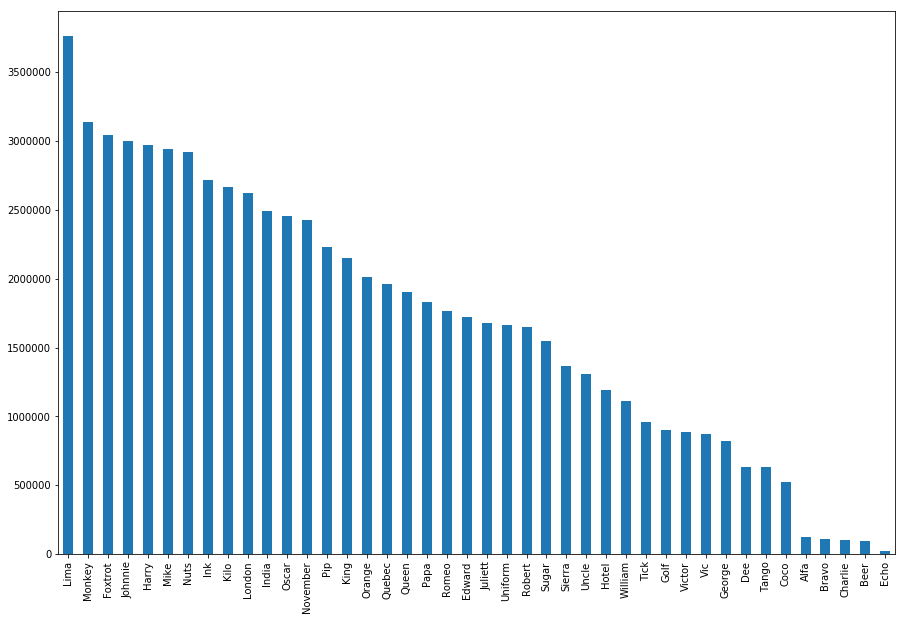

In [8]:
base_detection_counts = c_data.agentName.value_counts()
base_detection_counts.plot(kind="bar")

In [9]:
bd = base_detection_counts.to_frame().reset_index()
bd.columns =['agentName', "detection_count"]
bd = baseStationData.merge(bd, on="agentName")
bd.head()

,agentId,agentName,x,y,detection_count
0,000000006c1a3b5a,Alfa,3323.405966,9086.502512,127632
1,0000000020294bbd,Beer,3313.076869,2665.631392,95147
2,000000001159bb8a,Bravo,12030.636380,12272.735060,106587
3,000000004cb3ff60,Charlie,11735.001530,2912.053116,100910
4,00000000fe8992e8,Coco,23952.569160,6581.987542,523101


OK, at this point we can see that the north end of the office is getting much more action than the south and especially the west.

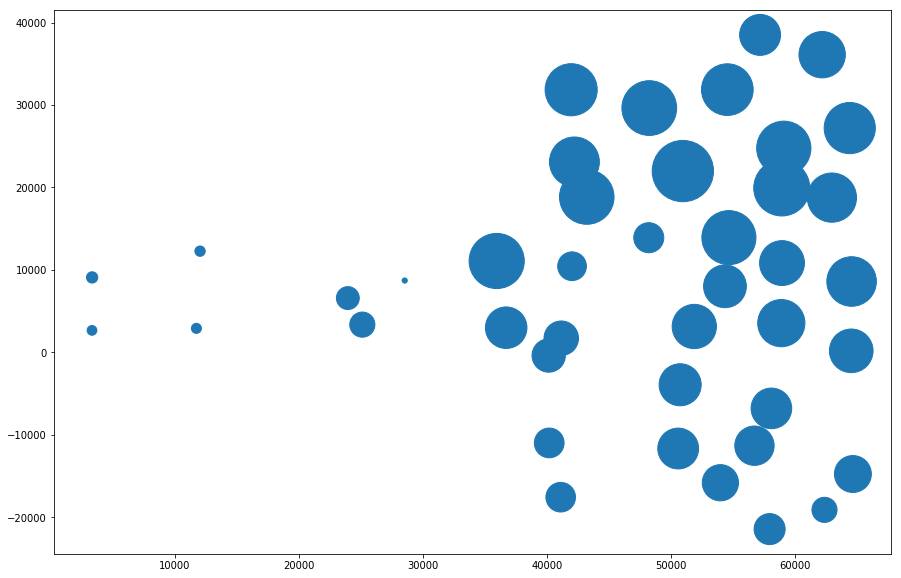

In [10]:
plt.scatter(bd.x, bd.y, s=bd.detection_count/1000, marker='o')#, c=sizes)

In an ideal world we'd see that only the badges that we care about are in the west end of the office.

In [11]:
badge_numbers = c_data.minor.unique()
print("there are {} badges detected in this period, they are:\n{}".format(len(badge_numbers), badge_numbers))

there are 65 badges detected in this period, they are:
[  288   404    23   371   388   296   304   357     5   384   369     7
   256   385   375   405   116    72   401   153   358   131    39    86
   409    84   354   387   402     3   393   355   400   390   361   360
   294    18   406    82   403   386   372   392   275   377   374   407
    50   359   370    32   295   130   368   353   391   114   145   100
 34816   120 29184   152 21504]


In [12]:
agent_names = c_data.agentName.unique()

data = pd.DataFrame(index=agent_names)

for i in range(0, len(badge_numbers)):
    s = c_data[c_data.minor==badge_numbers[i]].groupby("agentName").count().minor.to_frame()
    s.columns = [badge_numbers[i]]
    data = pd.concat([data, s], axis=1, join="outer")

data.fillna(0, inplace=True)
data.apply(pd.to_numeric)
data.head()

,288,404,23,371,388,296,304,357,5,384,...,353,391,114,145,100,34816,120,29184,152,21504
Alfa,0.0,0.0,0.0,16.0,0.0,0.0,3930,1749,712,0.0,...,0.0,1244,6,0.0,90914.0,0.0,0.0,0.0,0.0,0.0
Beer,0.0,0.0,0.0,0.0,0.0,0.0,3808,400,46,0.0,...,0.0,641,6,0.0,74478.0,0.0,0.0,0.0,0.0,0.0
Bravo,0.0,0.0,0.0,0.0,0.0,0.0,3822,541,62,0.0,...,0.0,808,3,0.0,82954.0,0.0,0.0,0.0,0.0,1.0
Charlie,0.0,0.0,0.0,0.0,0.0,0.0,3342,595,99,0.0,...,0.0,872,5,0.0,75539.0,0.0,0.0,0.0,0.0,0.0
Coco,0.0,1.0,491.0,23331.0,0.0,0.0,3110,22902,18451,0.0,...,0.0,1973,4135,0.0,50501.0,0.0,0.0,0.0,34.0,0.0


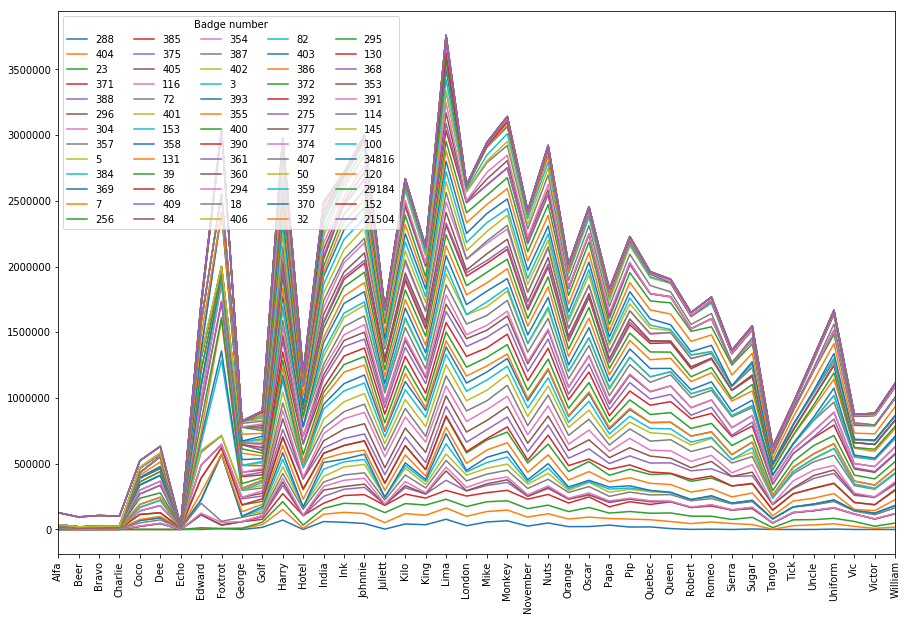

In [13]:
data.plot(stacked=True)
x = range(0, len(agent_names), 1)
plt.xticks(x)
plt.xticks(x, data.index, rotation='vertical')
plt.legend(loc="upper left", bbox_to_anchor=[0, 1],
           ncol=5, shadow=False, title="Badge number", fancybox=True)

So it seems like this plot isn't actually that useful in identifying what we're looking for.

Let's try just getting the badges that show up on ace, beer, bravo and charlie.

In [14]:
abbc = c_data[c_data.agentName.isin( ["Ace", "Beer", "Bravo", "Charlie"] )]
print (abbc.info())
abbc.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 302644 entries, 65041155 to 69146364
Data columns (total 5 columns):
minor        302644 non-null int32
time         302644 non-null datetime64[ns]
rssi         302644 non-null int32
agentId      302644 non-null object
agentName    302644 non-null object
dtypes: datetime64[ns](1), int32(2), object(2)
memory usage: 11.5+ MB
None


,minor,time,rssi,agentId,agentName
65041155,100,2016-11-23 23:06:34.296,-42,000000001159bb8a,Bravo
65041156,100,2016-11-23 23:06:35.245,-49,000000001159bb8a,Bravo
65041157,100,2016-11-23 23:06:37.152,-40,000000001159bb8a,Bravo
65041158,100,2016-11-23 23:06:39.056,-43,000000001159bb8a,Bravo
65041159,100,2016-11-23 23:06:40.011,-49,000000001159bb8a,Bravo


So for some reason, badge 100 is massively more represented than the rest of them. Let's take it out for the moment.

In [15]:
abbc = abbc[abbc.minor != 100]

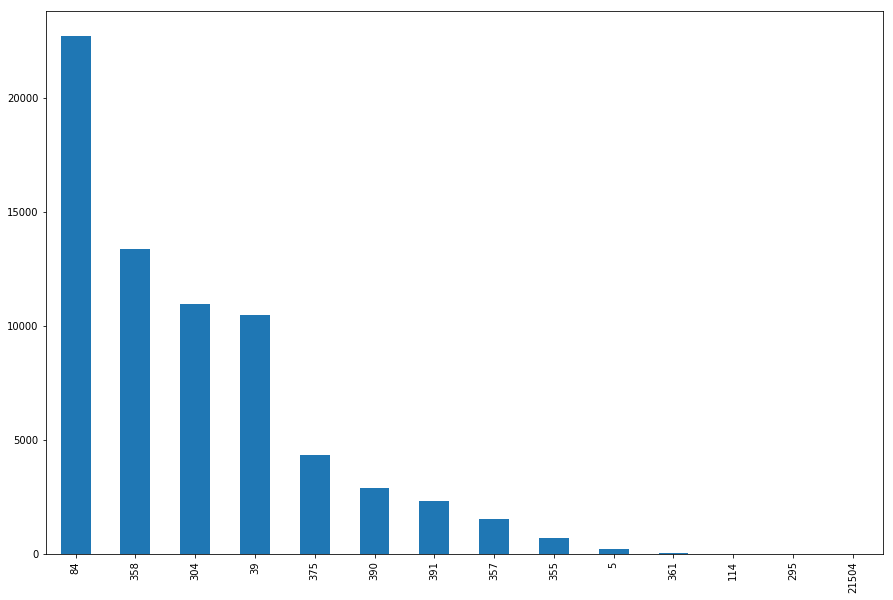

In [16]:
abbc.minor.value_counts().plot(kind="bar")

This is consistent with the right number of badges used for the training. Probably time to start overlapping these as paths with the paths from the training data.

Looking at just `84` it seems like this badge was used four times, which makes sense as it's the one that gets detected the most.

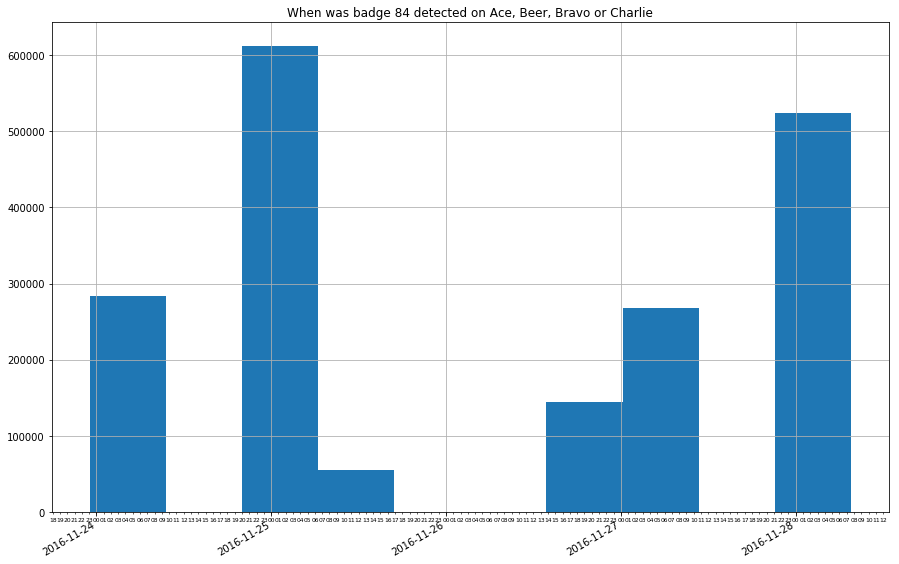

In [17]:
just84 = c_data[c_data.minor == 84]
fig, ax = plt.subplots()
just84.time.hist()
plt.title("When was badge 84 detected on Ace, Beer, Bravo or Charlie")

days = mdates.DayLocator()
hours = mdates.HourLocator()
majorFmt = mdates.DateFormatter('%Y-%m-%d')
minorFmt = mdates.DateFormatter('%H')
# format the ticks
ax.xaxis.set_major_locator(days)
ax.xaxis.set_major_formatter(majorFmt)
ax.xaxis.set_minor_locator(hours)
ax.xaxis.set_minor_formatter(minorFmt)
ax.tick_params(axis='both', which='minor', labelsize=6)
fig.autofmt_xdate()

In [20]:
# TODO start to break this badge's walks up into time periods
# just84.between_time(start_time, end_time, include_start=True, include_end=True)

In [21]:
bd_count84 = just84.agentName.value_counts()

bd84 = bd_count84.to_frame().reset_index()
bd84.columns =['agentName', "detection_count"]

bd84 = bd84.merge(baseStationData, on="agentName", how='inner')
bd84.head()

,agentName,detection_count,agentId,x,y
0,Foxtrot,136276,00000000b6672df6,35960.91108,11080.346200
1,Queen,64260,000000002f9f3fae,64563.83402,184.039074
2,Nuts,63589,00000000b648975e,54694.91171,13912.061020
3,Edward,62401,000000000b41629a,36726.34790,2989.947093
4,Oscar,60993,0000000084e99283,64593.33902,8591.970509


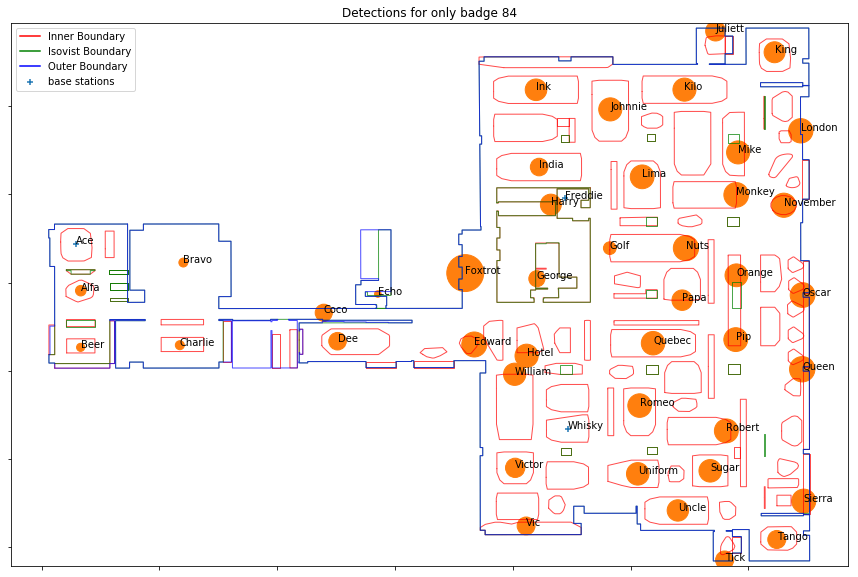

In [22]:
fig, ax = draw_infrastructure(title="Detections for only badge 84",
                              draw_boundaries=True, 
                              draw_stickers=False, 
                              draw_basestations=True, 
                              draw_seat_names=False,
                              draw_graph=False,
                              return_plt_object=True)
ax.scatter(bd84.x, bd84.y, s=bd84.detection_count/100, marker='o') 
plt.show()

This looks really promising, there seems to be a good distribution of detections across the space.